In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#from preprocess import train_test_seq#, scale_df
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline

In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score, median_absolute_error
from sklearn.metrics import make_scorer

def mean_absolute_percentage_error(y_true, y_pred, eps = 1e-4): 
    # Avoid values too close to zero
    idxs = np.abs(y_true) > eps
    return np.mean(np.abs((y_true[idxs] - y_pred[idxs]) / y_true[idxs])) * 100 
#if y_true != 0 else 0.0

In [4]:
mape = make_scorer(mean_absolute_percentage_error, 
                   greater_is_better=False)

In [18]:
def print_scores(y_test, y_pred):
    print(f"R2 score: {r2_score(y_test, y_pred)}")
    print(f"MSE score: {mean_squared_error(y_test, y_pred)}")
    print(f"MAE score: {mean_absolute_error(y_test, y_pred)}")
    print(f"MAPE score: {mean_absolute_percentage_error(y_test, y_pred)}")
    print(f"Median AE score: {median_absolute_error(y_test, y_pred)}")

In [5]:
# Load in the time series
candy = pd.read_csv('candy_production.csv', 
            index_col='date',
            parse_dates=True)
candy.head()

,IPG3113N
date,
1972-01-01,85.598809
1972-02-01,71.741404
1972-03-01,65.948809
1972-04-01,64.490724
1972-05-01,64.933842


In [6]:
candy.shape

(564, 1)

## Train/Test split

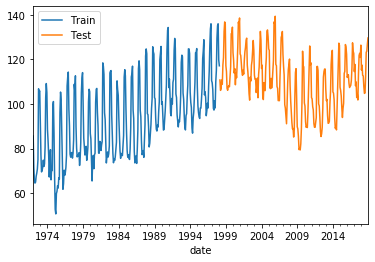

In [7]:
# Split the data into a train and test set
df_train, df_test = candy.iloc[:-250], candy.iloc[-250:]

# Create an axis
fig, ax = plt.subplots()

# Plot the train and test setsa dn show
df_train.plot(ax=ax)
df_test.plot(ax=ax)
plt.axvline(x=4000, color='k', linestyle='--')
ax.legend(["Train", "Test"]);
plt.show()

In [26]:
X_train = df_train[-200:-100].to_numpy().reshape(-1,1)
X_test  = df_test[-100:-50].to_numpy().reshape(-1,1)

y_train = df_train[-200:-100].to_numpy().ravel()
y_test  = df_test[-100:-50].to_numpy().ravel() 

## Baseline

### 1. Last value

In [31]:
y_base1 = np.copy(y_test)
y_base1[:] = y_test[0]

In [32]:
print_scores(y_test, y_base1)

R2 score: -1.3054096851080859
MSE score: 301.0344616027514
MAE score: 14.55646536098103
MAPE score: 15.335489207901364
Median AE score: 14.749034517678275


### 2. Rolling mean

In [29]:
candy_rolling_mean = candy.rolling(20).mean()

y_base2 = candy_rolling_mean.iloc[-50:].to_numpy()

In [33]:
print_scores(y_test, y_base2)

R2 score: -0.5779220822805284
MSE score: 206.04100327970173
MAE score: 12.597029899741681
MAPE score: 13.00294755813918
Median AE score: 12.558113696716205


## Pipeline

In [9]:
pipe_lasso = Pipeline([
                       ('scale',  MinMaxScaler(feature_range=(-1, 1))),
                       ('lasso', Lasso())
                       ])

pipe_rf = Pipeline([
                    ('scale',  MinMaxScaler(feature_range=(-1, 1))),
                    ('rf', RandomForestRegressor(random_state=42))
                    ])

In [10]:
params_lasso = {'lasso__alpha': np.logspace(-4,1,10)}
              
params_rf = {
             #'rf__criterion': ['mae', 'mse'],
             'rf__max_depth': [2, 4, 8],
             #'rf__max_features': ['auto', 'sqrt', None],
             'rf__min_samples_leaf': [2, 4, 8],
             'rf__n_estimators': [8, 16, 32, 64]
            }

## GridSearchCV

### LASSO

In [11]:
my_cv = TimeSeriesSplit(n_splits=2).split(X_train)

gs_lasso = GridSearchCV(pipe_lasso,
                        param_grid=params_lasso,
                        scoring='neg_mean_absolute_error',
                        cv=my_cv,
                        n_jobs=4) 

In [12]:
# Fit to the training set
gs_lasso.fit(X_train,y_train)

# Predict
y_pred_lasso = gs_lasso.predict(X_test)

# Compute and print the metrics
print(f"Tuned Lasso Alpha: {gs_lasso.best_params_}")
print(f"Tuned Lasso Score: {gs_lasso.score(X_test, y_test)}")

Tuned Lasso Alpha: {'lasso__alpha': 0.0001}
Tuned Lasso Score: -0.00012362099709946505


In [19]:
print_scores(y_test, y_pred_lasso)

R2 score: 0.999999999802324
MSE score: 2.581202389221337e-08
MAE score: 0.00012362099709946505
MAPE score: 0.00011171078544783127
Median AE score: 8.836471692319492e-05


### Random Forests

In [13]:
my_cv = TimeSeriesSplit(n_splits=2).split(X_train)

gs_rf = GridSearchCV(estimator=pipe_rf,
                     param_grid=params_rf,
                     scoring='neg_mean_absolute_error',
                     cv=my_cv, 
                     n_jobs=4)

In [14]:
# Fit to the training set
gs_rf.fit(X_train,y_train)

# Predict
y_pred_rf = gs_rf.predict(X_test)

# Compute and print the metrics
print(f"Tuned RF params: {gs_rf.best_params_}")
print(f"Tuned RF Score:  {gs_rf.score(X_test, y_test)}")

Tuned RF params: {'rf__max_depth': 8, 'rf__min_samples_leaf': 2, 'rf__n_estimators': 64}
Tuned RF Score:  -0.537326968658403


In [20]:
print_scores(y_test, y_pred_rf)

R2 score: 0.9956480123381775
MSE score: 0.5682713450633972
MAE score: 0.537326968658403
MAPE score: 0.5279765612807384
Median AE score: 0.3482803056149564


## Plot `y_pred`

In [15]:
y_pred_lasso.shape, y_pred_rf.shape

((50,), (50,))

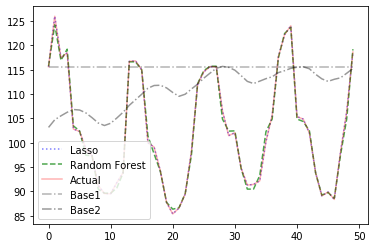

In [34]:
#t_test = np.linspace(4000, 4000+tst_sz, tst_sz)

plt.plot(y_pred_lasso, 'b:', label='Lasso', alpha=0.5)
plt.plot(y_pred_rf, 'g--', label='Random Forest', alpha=0.7)
plt.plot(y_test, 'r', label='Actual', alpha=0.3)
plt.plot(y_base1, 'k-.', label='Base1', alpha=0.3)
plt.plot(y_base2, 'k-.', label='Base2', alpha=0.4)
plt.legend()